In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import json
from zipfile import ZipFile

!mkdir .kaggle

token = {"username":"cameronwebster","key":"5e70b65a76b1214dee43d83e7143f395"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

!mkdir ~/.kaggle
!echo '{"username":"cameronwebster","key":"5e70b65a76b1214dee43d83e7143f395"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json && pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!rm -r cassava-leaf-disease-classification
!mkdir cassava-leaf-disease-classification
!kaggle competitions download -c cassava-leaf-disease-classification -p cassava-leaf-disease-classification

file_name = '/content/cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip'

with ZipFile(file_name, 'r') as zip:

  print("Extracting new files")
  zip.extractall()
  print("done!")

In [ ]:
import tensorflow as tf
import numpy as np
from functools import partial
from tensorflow.keras.losses import categorical_crossentropy
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_curve, r2_score, confusion_matrix)
from sklearn.utils.multiclass import unique_labels

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_SEED = 42
BATCH_SIZE = 16 
# IMAGE_SIZE = [336, 336]
CROP_FACTOR = 0.7
IMAGE_SIZE = [int((520*CROP_FACTOR)-4)] * 2
CLASSES = 5
TRAIN_SPLIT = 0.8

RECORD_PATH = tf.io.gfile.glob("train_tfrecords/*.tfrec")
RESNET_50_PATH = '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/ResNet50_final.hdf5'
INCEPTION_PATH = '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/InceptionNet_final.hdf5'
EFFICIENT_PATH = '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/EfficientNet_final.hdf5'
ENSEMBLER_PATH = '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/EnsembleNet_final.hdf5'

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image_raw = image

    image = tf.cast(image, tf.float32)
    image = tf.image.central_crop(image, CROP_FACTOR)
    image = image / 255.0 # recale by 255 for inputs between 0 and 1

    return image, image_raw


def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image, image_raw = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        label = tf.one_hot(label, 5)
        return image, image_raw, label
    return image, image_raw


def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset


def get_val_dataset(filenames, labeled=True, train_split=TRAIN_SPLIT):

    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048, seed=SHUFFLE_SEED)

    # Size of dataset
    n = sum(1 for _ in dataset)
    n_train = int(n * train_split)
    n_valid = n - n_train

    val_dataset = dataset.skip(n_train).take(n_valid)

    return val_dataset

In [ ]:
val_dataset = get_val_dataset(RECORD_PATH)
val_dataset = list(val_dataset.as_numpy_iterator())

In [ ]:
X = np.array([x for x, _, _ in val_dataset])
X_raw = np.array([x for _, x, _ in val_dataset])
Y_true = np.array([y for _, _, y in val_dataset])

In [ ]:
resnet_50_model = tf.keras.models.load_model(RESNET_50_PATH)
efficient_model = tf.keras.models.load_model(EFFICIENT_PATH)
inception_model = tf.keras.models.load_model(INCEPTION_PATH)
ensembler_model = tf.keras.models.load_model(ENSEMBLER_PATH)

Y_pred_resnet_50 = resnet_50_model.predict(X)
Y_pred_efficient = efficient_model.predict(X)
Y_pred_inception = inception_model.predict(X)
Y_pred_ensembler = ensembler_model.predict(X)

In [ ]:
y_pred_argmaxs_resnet_50 = np.array([np.argmax(i) for i in Y_pred_resnet_50])
y_pred_argmaxs_efficient = np.array([np.argmax(i) for i in Y_pred_efficient])
y_pred_argmaxs_inception = np.array([np.argmax(i) for i in Y_pred_inception])
y_pred_argmaxs_ensembler = np.array([np.argmax(i) for i in Y_pred_ensembler])

y_true_argmaxs = np.array([np.argmax(i) for i in Y_true])

resnet_50_acc = accuracy_score(y_true_argmaxs, y_pred_argmaxs_resnet_50)
efficient_acc = accuracy_score(y_true_argmaxs, y_pred_argmaxs_efficient)
inception_acc = accuracy_score(y_true_argmaxs, y_pred_argmaxs_inception)
ensembler_acc = accuracy_score(y_true_argmaxs, y_pred_argmaxs_ensembler)

print(f"Resnet50 Accuracy Score: {resnet_50_acc}")
print(f"EfficientNet Accuracy Score: {efficient_acc}")
print(f"Inception Accuracy Score: {inception_acc}")
print(f"Ensembler Accuracy Score: {ensembler_acc}")

Resnet50 Accuracy Score: 0.8394859813084112
EfficientNet Accuracy Score: 0.9119158878504673
Inception Accuracy Score: 0.8698598130841122
Inception Accuracy Score: 0.9025700934579439


In [ ]:
y_losses_resnet_50 = [categorical_crossentropy(Y_true[i], Y_pred_resnet_50[i]).numpy() for i in range(len(Y_true))]
y_losses_efficient = [categorical_crossentropy(Y_true[i], Y_pred_efficient[i]).numpy() for i in range(len(Y_true))]
y_losses_inception = [categorical_crossentropy(Y_true[i], Y_pred_inception[i]).numpy() for i in range(len(Y_true))]
y_losses_ensembler = [categorical_crossentropy(Y_true[i], Y_pred_ensembler[i]).numpy() for i in range(len(Y_true))]

In [ ]:
top_loss_indexes_resnet_50 = np.argsort(y_losses_resnet_50)[::-1][:25]
top_loss_indexes_efficient = np.argsort(y_losses_efficient)[::-1][:25]
top_loss_indexes_inception = np.argsort(y_losses_inception)[::-1][:25]
top_loss_indexes_ensembler = np.argsort(y_losses_ensembler)[::-1][:25]

top_loss_images_resnet_50 = np.array([X_raw[i] for i in top_loss_indexes_resnet_50])
top_loss_images_efficient = np.array([X_raw[i] for i in top_loss_indexes_efficient])
top_loss_images_inception = np.array([X_raw[i] for i in top_loss_indexes_inception])
top_loss_images_ensembler = np.array([X_raw[i] for i in top_loss_indexes_ensembler])

top_loss_labels_resnet_50 = np.array([np.argmax(Y_true[i]) for i in top_loss_indexes_resnet_50])
top_loss_labels_efficient = np.array([np.argmax(Y_true[i]) for i in top_loss_indexes_efficient])
top_loss_labels_inception = np.array([np.argmax(Y_true[i]) for i in top_loss_indexes_inception])
top_loss_labels_ensembler = np.array([np.argmax(Y_true[i]) for i in top_loss_indexes_ensembler])

top_loss_predictions_resnet_50 = np.array([np.argmax(Y_pred_resnet_50[i]) for i in top_loss_indexes_resnet_50])
top_loss_predictions_efficient = np.array([np.argmax(Y_pred_efficient[i]) for i in top_loss_indexes_efficient])
top_loss_predictions_inception = np.array([np.argmax(Y_pred_inception[i]) for i in top_loss_indexes_inception])
top_loss_predictions_ensembler = np.array([np.argmax(Y_pred_ensembler[i]) for i in top_loss_indexes_ensembler])

In [ ]:
plt.figure(figsize=(10,10))
for n in range(25):
  ax = plt.subplot(5, 5, n + 1)
  plt.imshow(top_loss_images_resnet_50[n] / 255.0)
  plt.title(f"label: {top_loss_labels_resnet_50[n]}, prediction: {top_loss_predictions_resnet_50[n]}", fontsize='medium')
  plt.axis("off")
plt.suptitle('ResNet50 Worst Performing Images', fontsize='xx-large')
plt.savefig('/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/ResNet50_worst.png')

In [ ]:
plt.figure(figsize=(10,10))
for n in range(25):
  ax = plt.subplot(5, 5, n + 1)
  plt.imshow(top_loss_images_efficient[n] / 255.0)
  plt.title(f"label: {top_loss_labels_efficient[n]}, prediction: {top_loss_predictions_efficient[n]}", fontsize='medium')
  plt.axis("off")
plt.suptitle('EfficientNet Worst Performing Images', fontsize='xx-large')
plt.savefig('/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/Efficient_worst.png')

In [ ]:
plt.figure(figsize=(10,10))
for n in range(25):
  ax = plt.subplot(5, 5, n + 1)
  plt.imshow(top_loss_images_inception[n] / 255.0)
  plt.title(f"label: {top_loss_labels_inception[n]}, prediction: {top_loss_predictions_inception[n]}", fontsize='medium')
  plt.axis("off")
plt.suptitle('InceptionNet Worst Performing Images', fontsize='xx-large')
plt.savefig('/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/Inception_worst.png')

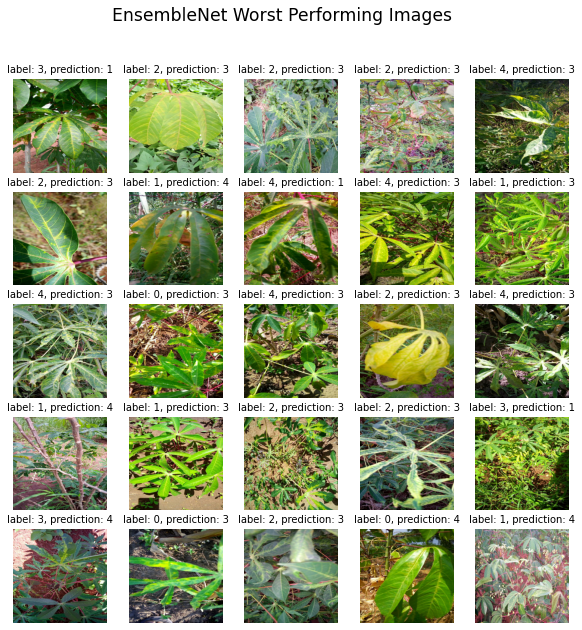

In [ ]:
plt.figure(figsize=(10,10))
for n in range(25):
  ax = plt.subplot(5, 5, n + 1)
  plt.imshow(top_loss_images_inception[n] / 255.0)
  plt.title(f"label: {top_loss_labels_ensembler[n]}, prediction: {top_loss_predictions_ensembler[n]}", fontsize='medium')
  plt.axis("off")
plt.suptitle('EnsembleNet Worst Performing Images', fontsize='xx-large')
plt.savefig('/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/Ensemble_worst.png')

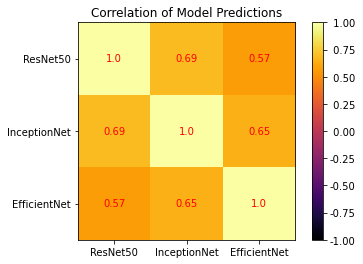

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred_matrix = np.vstack((y_pred_argmaxs_resnet_50, 
                           y_pred_argmaxs_inception,
                           y_pred_argmaxs_efficient))

corr_matrix = np.corrcoef(y_pred_matrix).round(decimals=2)

fig, ax = plt.subplots()
im = ax.imshow(corr_matrix, cmap='inferno')
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('ResNet50', 'InceptionNet', 'EfficientNet'))
ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('ResNet50', 'InceptionNet', 'EfficientNet'))
ax.set_ylim(2.5, -0.5)
for i in range(3):
    for j in range(3):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
                color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.title("Correlation of Model Predictions")
plt.show()
plt.savefig('/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/correlation.png')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, savename,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(savename)
    return ax

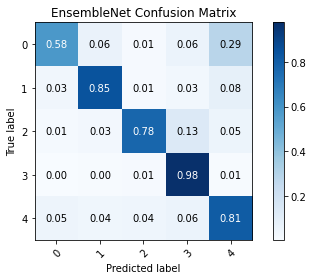

In [ ]:
plot_confusion_matrix(y_true_argmaxs, 
                      y_pred_argmaxs_resnet_50, 
                      range(5),
                      '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/ResNet50_Confusion.png',
                      normalize=True, 
                      title="ResNet50 Confusion Matrix")

plot_confusion_matrix(y_true_argmaxs, 
                      y_pred_argmaxs_inception, 
                      range(5), 
                      '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/Inception_Confusion.png',
                      normalize=True, 
                      title="InceptionNet Confusion Matrix")

plot_confusion_matrix(y_true_argmaxs, 
                      y_pred_argmaxs_efficient, 
                      range(5), 
                      '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/EfficientNet_Confusion.png', 
                      normalize=True, 
                      title="EfficientNet Confusion Matrix")

plot_confusion_matrix(y_true_argmaxs, 
                      y_pred_argmaxs_ensembler, 
                      range(5), 
                      '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/test_checkpoints/EnsembleNet_Confusion.png', 
                      normalize=True, 
                      title="EnsembleNet Confusion Matrix")